In [197]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.4 MB/s eta 0:00:00


In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import math
import textstat
from pathlib import Path
from google.colab import drive
import spacy
from wordcloud import WordCloud
from textwrap import wrap
import nltk
import itertools
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import wordnet
from nltk.util import ngrams
from textblob import TextBlob

In [ ]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# Importing dataset
df=pd.read_csv("/drive/My Drive/Colab Notebooks/quora_questions_answers_csv.csv") 
print("Shape of data=>",df.shape) 

Shape of data=> (222, 10)


In [ ]:
#remove null values 
df.isnull().sum()

question_name            0
question_url           125
question_views         125
question_upvotes       125
question_shares        125
question_comments      137
answer                 127
question_date           97
question_date_url       97
question_shares_url    221
dtype: int64

In [ ]:
#replace nan in answer with empty string
df['answer'] = df['answer'] .replace(np.nan, '', regex=True)

In [ ]:
df = df[['question_name','question_views','question_upvotes','question_comments','question_shares','answer']]

In [ ]:
df.dtypes

question_name        object
question_views       object
question_upvotes     object
question_comments    object
question_shares      object
answer               object
dtype: object

In [ ]:
#values in comments,shares columns were interchanged for one record 
num_comments = df.iloc[15,4]
num_shares = df.iloc[15,2]
df.iloc[15,3] = num_comments
df.iloc[15,4] = num_shares
df.iloc[15,2] = np.nan

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [ ]:
#remove k,m from views
df.question_views = (df.question_views.replace(r'[KMviews]+', '', regex=True).astype(float) *  df.question_views.str.extract(r'[\d\.]+([KM]+)', expand=False)
            .fillna(1)
            .replace(['K','M'], [10**3, 10**6]).astype(int))

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
#remove k,m from upvotes
df.question_upvotes = (df.question_upvotes.replace(r'[KMupvotes]+', '', regex=True).astype(float) *  df.question_upvotes.str.extract(r'[\d\.]+([KM]+)', expand=False)
            .fillna(1)
            .replace(['K','M'], [10**3, 10**6]).astype(int))

In [ ]:
#remove k,m from shares
df.question_shares = (df.question_shares.replace(r'[KMshares| KMcomment]+', '', regex=True).astype(float) *  df.question_shares.str.extract(r'[\d\.]+([KM]+)', expand=False)
            .fillna(1)
            .replace(['K','M'], [10**3, 10**6]).astype(int))

In [ ]:
#remove k,m from comments
df.question_comments = (df.question_comments.replace(r'[KMcomments|KMshares]+', '', regex=True).astype(float) *  df.question_comments.str.extract(r'[\d\.]+([KM]+)', expand=False)
            .fillna(1)
            .replace(['K','M'], [10**3, 10**6]).astype(int))

In [ ]:
df.describe()

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have", "what's":"what is"}



In [ ]:
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [ ]:
# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

In [ ]:
# Expanding Contractions in the questions,answers
df['question_name']=df['question_name'].apply(lambda x:expand_contractions(x))
df['answer']=df['answer'].apply(lambda x:expand_contractions(x))

<ipython-input-94-dc50a1bb42bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['question_name']=df['question_name'].apply(lambda x:expand_contractions(x))


In [ ]:
#convert answers, questions to lower case
df['question_name']=df['question_name'].apply(lambda x: x.lower())
df['answer']=df['answer'].apply(lambda x: x.lower())

#remove links from question
df['question_name'] = df['question_name'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

#remove links from answers
df['answer'] = df['answer'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

#remove punctuations, digits and words with digits 
df['question_name']=df['question_name'].apply(lambda x: re.sub('\d+','', x))
df['question_name']=df['question_name'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df['answer']=df['answer'].apply(lambda x: re.sub('\d+','', x))
df['answer']=df['answer'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# Removing extra spaces
df['question_name']=df['question_name'].apply(lambda x: re.sub(' +',' ',x))
df['answer']=df['answer'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

In [ ]:
# Lemmatization with stopwords removal
df['lemmatized']=df['question_name'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

# Lemmatization answers with stopwords removal
df['lemmatized_answers']=df['answer'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [177]:
df_grouped=df[['question_name','lemmatized']].groupby(by='question_name').agg(lambda x:' '.join(x))
df_grouped.head()

df_grouped_all_questions = pd.DataFrame()
df_grouped_all_questions['question_name'] = [' '.join(df["question_name"])]
df_grouped_all_questions['lemmatized']=df_grouped_all_questions['question_name'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
df_grouped_all_questions=df_grouped_all_questions[['question_name','lemmatized']].groupby(by='question_name').agg(lambda x:' '.join(x))

In [187]:
df_grouped.head()

,lemmatized,polarity
question_name,,
are canadians richer than americans their quality of life is better than americans they are the number country in the world for quality of life and make and get way more money than any american,canadian rich americans quality life well amer...,0.1875
are there any infamous women who committed crimes in order to get rich like db cooper,infamous woman commit crime order rich like db...,-0.0625
can a wealthy person be a communist,wealthy person communist,0.5000
can someone make money from online stock market trading without any prior knowledge or experience in this field if yes then how can one do that and what are some tips for doing so,money online stock market trading prior knowle...,0.0000
can technical analysis be used to predict the end of a bear market without taking any fundamental analysis into account,technical analysis predict end bear market tak...,0.0000


In [178]:
df_grouped_answers=df[['answer','lemmatized_answers']].groupby(by='answer').agg(lambda x:' '.join(x))
df_grouped_answers.head()

df_grouped_all_answers = pd.DataFrame()
df_grouped_all_answers['answer'] = [' '.join(df["answer"])]
df_grouped_all_answers['lemmatized_answers']=df_grouped_all_answers['answer'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
df_grouped_all_answers=df_grouped_all_answers[['answer','lemmatized_answers']].groupby(by='answer').agg(lambda x:' '.join(x))

In [163]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [150]:
# Creating Document Term Matrix for question
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped_all_questions['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped_all_questions.index

In [149]:
# Creating Document Term Matrix for answer
data_ans=cv.fit_transform(df_grouped_all_answers['lemmatized_answers'])
df_dtm_ans = pd.DataFrame(data_ans.toarray(), columns=cv.get_feature_names())
df_dtm_ans.index=df_grouped_all_answers.index

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


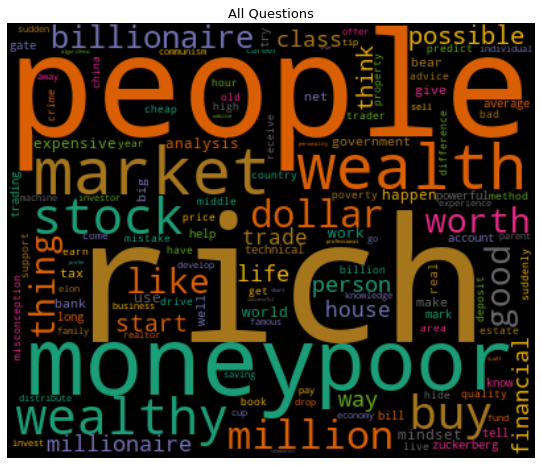

In [151]:
# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for questions
for index,q in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[q].sort_values(ascending=False),"All Questions")

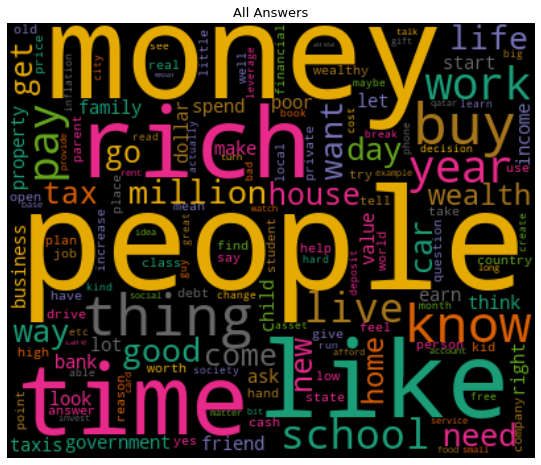

In [152]:
# Transposing document term matrix - answers
df_dtm_ans=df_dtm_ans.transpose()

# Plotting word cloud for answers
for index,a in enumerate(df_dtm_ans.columns):
  generate_wordcloud(df_dtm_ans[a].sort_values(ascending=False),"All Answers")

In [159]:
def all_stopwords(stopwords_list):
    ''' return list of all the stopwords including common stop words in english and stopwords list by the user
    '''
    stopwords = nltk.corpus.stopwords.words('english')
    # extend the default stopwords list by adding additional stopwords
    stopwords.extend(stopwords_list)
    return stopwords

def get_filtered_tokens(df, column_name, stopwords_list):
    ''' tokenize the elements of column of dataframe
    '''
    words_list = df[column_name].tolist()
    stop_words = all_stopwords(stopwords_list)
    tokens = [word_tokenize(i) for i in words_list]
    #error
    filtered_tokens = [word for word in tokens if word not in stop_words]
    filtered_tokens = [word for word in filtered_tokens if len(word) > 5]
    return filtered_tokens

def most_common_words(filtered_tokens, num_common_words):
    filtered_tokens = list(itertools.chain(*filtered_tokens))
    fdist = nltk.FreqDist(filtered_tokens)
    common_words = fdist.most_common(num_common_words)
    return common_words

In [164]:
#list of additional stopwords depending on the dataset
stopwords = ['im','cant', 'dont', 'get', 'etc', 'ha', 'could', 'u','hi'] # some error as the additional stopswords aren't removed

# Tokenization followed by filteration on the basis of stopwords i.e., get the tokens after removing the stopwords
filtered_tokens = get_filtered_tokens(df, 'answer', stopwords)

# how many most common words to find
num_common_words = 300

# list of most common words
common_words = most_common_words(filtered_tokens, num_common_words)
print(common_words)

[('the', 1068), ('to', 766), ('a', 733), ('and', 725), ('of', 585), ('in', 465), ('i', 435), ('is', 434), ('you', 429), ('’', 387), ('it', 375), ('that', 355), ('for', 260), ('have', 231), ('they', 212), ('not', 211), ('are', 204), ('this', 178), ('my', 177), ('on', 176), ('people', 175), ('s', 161), ('money', 160), ('or', 158), ('if', 157), ('be', 156), ('t', 148), ('but', 148), ('with', 147), ('was', 147), ('as', 144), ('can', 136), ('so', 134), ('your', 130), ('we', 127), ('do', 122), ('will', 116), ('more', 107), ('from', 104), ('about', 103), ('would', 103), ('their', 99), ('who', 98), ('he', 97), ('at', 95), ('like', 92), ('what', 91), ('all', 90), ('just', 88), ('one', 86), ('no', 83), ('because', 81), ('had', 81), ('by', 81), ('me', 78), ('an', 76), ('there', 76), ('time', 70), ('rich', 70), ('most', 67), ('some', 66), ('get', 65), ('“', 63), ('his', 63), ('”', 62), ('how', 61), ('make', 60), ('don', 58), ('when', 58), ('than', 58), ('much', 57), ('out', 57), ('has', 55), ('cou

**Text Length**

In [165]:
def text_length(dataset, column_name):
    ''' calculate the average length of words in the text eg: Answers
    by taking the sum of the lengths of all the answers in the dataset, divided by the total number of answers
    '''
    text_list = dataset[column_name].tolist()
    tokens = [word_tokenize(t) for t in text_list if isinstance(t, str)]
    lengths = [len(t) for t in tokens]
    avg_length = round(sum(lengths) / len(lengths))
    max_length = max(lengths)
    min_length = min(lengths)
    return avg_length, max_length, min_length

In [166]:
avg_length, max_length, min_length = text_length(df, 'answer')
print('Average length is:', avg_length)
print(f'Maximum and minimum length is {max_length} and {min_length}')

Average length is: 128
Maximum and minimum length is 1742 and 0


In [168]:
avg_length, max_length, min_length = text_length(df, 'question_name')
print('Average length is:', avg_length)
print(f'Maximum and minimum length is {max_length} and {min_length}')

Average length is: 16
Maximum and minimum length is 52 and 5


In [169]:
def find_ngrams(dataset, column_name, n):
    ''' Tokenize the text and find the N-grams
    ''' 
    text_list = dataset[column_name].tolist()
    tokens = [word_tokenize(a) for a in text_list]
    n_grams = [ngrams(t, n) for t in tokens]

    return n_grams

In [175]:
# N_grams in Answer
n_grams_answer = find_ngrams(df, 'answer', 3)
for g in n_grams_answer:
      print(next(g))

('to', 'deposit', 'million')
('because', 'they', 'don')
('as', 'someone', 'that')
('i', 'am', 'a')
('well', 'yes', 'unless')
('mike', 'tyson', 'earned')
('todd', 'and', 'julie')
('i', 'have', 'received')
('“', 'it', '’')
('think', 'about', 'it')
('i', 'will', 'never')
('there', 'is', 'no')
('it', 'has', 'to')
('for', 'me', 'i')
('question', '“', 'does')
('throughout', 'time', 'something')
('even', 'allowing', 'for')
('let', '’', 's')
('of', 'course', 'he')
('qatar', 'has', 'always')
('it', 'depends', 'on')
('it', 'is', 'a')
('studies', 'that', 'have')
('they', 'certainly', 'exist')
('i', 'do', 'not')
('my', 'family', 'were')
('a', 'couple', 'things')
('it', 'is', 'but')
('do', 'you', 'know')
('warwick', 'university', 'did')
('when', 'i', 'was')
('honestly', 'because', 'they')
('what', 'is', 'wealth')
('my', 'research', 'lab')
('very', 'unfortunate', 'but')
('about', '–', 'times')
('it', 'would', 'be')
('tell', 'anybody', 'except')
('before', 'you', 'blow')
('if', 'you', 'find')
('someo

StopIteration: ignored

In [176]:
# N_grams in question
n_grams_answer = find_ngrams(df, 'question_name', 3)
for g in n_grams_answer:
      print(next(g))

('what', 'would', 'happen')
('why', 'will', 'most')
('is', 'it', 'worth')
('what', 'efforts', 'do')
('do', 'you', 'have')
('which', 'is', 'more')
('how', 'do', 'you')
('i', 'have', 'received')
('what', 'is', 'a')
('do', 'children', 'of')
('do', 'affluent', 'people')
('do', 'you', 'agree')
('how', 'wealthy', 'do')
('poorlower', 'class', 'people')
('does', 'having', 'money')
('what', 'are', 'the')
('why', 'do', 'of')
('how', 'do', 'you')
('why', 'didn', '’')
('why', 'does', 'the')
('how', 'rich', 'is')
('do', 'most', 'millionaires')
('how', 'can', 'you')
('what', 'are', 'middle')
('are', 'there', 'any')
('how', 'do', 'children')
('what', 'happens', 'when')
('is', 'it', 'possible')
('what', 'are', 'the')
('does', 'being', 'rich')
('did', 'a', 'coworker')
('why', 'do', 'the')
('what', 'is', 'wealth')
('did', 'a', 'coworker')
('what', 'do', 'you')
('is', 'it', 'true')
('would', 'it', 'be')
('what', 'would', 'you')
('if', 'you', 'have')
('can', 'you', 'get')
('what', 'would', 'happen')
('wha

**Polarity in answers and questions **

---



In [182]:
df_grouped['polarity']=df_grouped['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)
df_grouped_answers['polarity']=df_grouped_answers['lemmatized_answers'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [194]:
print("3 Questions with Lowest Polarity:")
for index,q in enumerate(df_grouped['polarity'].sort_values(ascending=True)[:3].index):
  print('Question {}:\n'.format(index+1),q)

3 Questions with Lowest Polarity:
Question 1:
 why do liberals hate billionaires when all billionaires are liberals like mark zuckerberg and bill gates
Question 2:
 what is the worst part about being a billionaire
Question 3:
 what are some ways we can use machine learning and artificial intelligence for algorithmic trading in the stock market


In [192]:
print("3 Questions with Highest Polarity:")
for index,q in enumerate(df_grouped['polarity'].sort_values(ascending=False)[:3].index):
  print('Question {}:\n'.format(index+1),q)

3 Questions with Highest Polarity:
Question 1:
 if you won the lottery what is the first thing you would buy why
Question 2:
 what method have you been using to analyze and attain successful trades
Question 3:
 what are the best ways to invest money


In [193]:
print("3 Answers with Highest Polarity:")
for index,a in enumerate(df_grouped_answers['polarity'].sort_values(ascending=False)[:3].index):
  print('Question {}:\n'.format(index+1),a)

3 Answers with Highest Polarity:
Question 1:
 that’s easy you don’t get the money
if you win a lawsuit and the court issues a judgment you don’t get the money nobody hands you a check it’s up to you to collect
if you know the person you sued has a bank account you may be able to go to the bank with your judgment in hand give them the bank account number and put a freeze on their account if you know they own real estate you might be able to put a lien on it
but the point is winning a lawsuit doesn’t mean someone hands you a million dollars if they don’t have a million dollars you won’t get a million dollars maybe you might be able to get something maybe you might be able to garnish their wages but you will not be handed a million dollars
Question 2:
 what screams “i’m rich”
i married my best friend and am pathetically happy with him
i have three beautiful children who are well mannered and kind human beings who have plans to make a difference in society
i have the best friends in the wo

In [195]:
print("3 Answers with Lowest Polarity:")
for index,a in enumerate(df_grouped_answers['polarity'].sort_values(ascending=True)[:3].index):
  print('Question {}:\n'.format(index+1),a)

3 Answers with Lowest Polarity:
Question 1:
 about – times a week a question like one of these floats though my quora feed
now clearly not all conservatives are stupid however it’s sometimes hard to shake the idea that people who perhaps are below the median in native intelligence might tend to skew conservative
there is no federal property tax
joe biden is not raising property taxes because there is no federal property tax the president has no say in and no control over property taxes because property taxes are local not federal
same for rent control rent control laws are not set by the president because there are no federal rent control laws rent control is local not federal
if someone tells you “joe biden is raising property taxes and passing rent control laws” that person thinks you’re an idiot if you believe them they may be right
Question 2:
 because they don’t have the courage to ask for it — they don’t even think it’s a possibility
because they want quick fixes that course that

In [200]:
df['dale_chall_score']=df['answer'].apply(lambda x: textstat.dale_chall_readability_score(x))
df['flesh_reading_ease']=df['answer'].apply(lambda x: textstat.flesch_reading_ease(x))
df['gunning_fog']=df['answer'].apply(lambda x: textstat.gunning_fog(x))

print('Dale Chall Score of upvoted answers=>',df[df['question_upvotes']>1]['dale_chall_score'].mean())

print('Flesch Reading Score of upvoted answers=>',df[df['question_upvotes']>1]['flesh_reading_ease'].mean())

print('Gunning Fog Index of upvoted answers=>',df[df['question_upvotes']>1]['gunning_fog'].mean())

Dale Chall Score of upvoted answers=> 20.742291666666663
Flesch Reading Score of upvoted answers=> -191.12270833333332
Gunning Fog Index of upvoted answers=> 114.07968750000002
